In [ ]:
agv 90%
oht 94%

In [1]:
pip show numpy

Name: numpy
Version: 1.21.6
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: c:\users\82103\anaconda3\envs\tf37\lib\site-packages
Requires: 
Required-by: matplotlib, numba, opencv-python, pandas, scikit-learn, scipy, shap, tensorboard, torchvision
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import time

# 1. 멀티모달 데이터셋 정의
class MultimodalDataset(Dataset):
    def __init__(self, csv_path, bin_root_folder, split_folder, img_dim_h, img_dim_w):
        self.data = []
        self.img_dim_h = img_dim_h
        self.img_dim_w = img_dim_w

        # 모든 BIN 파일의 경로 수집
        bin_files = {}
        split_path = os.path.join(bin_root_folder, split_folder)
        for root, _, files in os.walk(split_path):
            for file in files:
                if file.endswith(".bin"):
                    bin_files[file] = os.path.join(root, file)

        # CSV 파일 읽기
        df = pd.read_csv(csv_path)
        #features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value"]
        features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_temperature", "ex_humidity", "ex_illuminance"]

        for _, row in df.iterrows():
            bin_filename = row['bin_filename']
            if bin_filename in bin_files:
                bin_path = bin_files[bin_filename]
                try:
                    img_data = np.load(bin_path).reshape((img_dim_h, img_dim_w))
                except Exception as e:
                    print(f"[Error] BIN 파일 로드 실패: {bin_path}, {e}")
                    continue

                aux_data = row[features].values.astype(np.float32)
                label = int(row['state'])
                self.data.append((img_data, aux_data, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data, aux_data, label = self.data[idx]
        img_data = torch.tensor(img_data, dtype=torch.float32).unsqueeze(0)
        aux_data = torch.tensor(aux_data, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return img_data, aux_data, label


# 2. 데이터 로더 함수
def load_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size=32):
    train_dataset = MultimodalDataset(csv_path, bin_root_folder, 'train', img_dim_h, img_dim_w)
    val_dataset = MultimodalDataset(csv_path, bin_root_folder, 'val', img_dim_h, img_dim_w)
    test_dataset = MultimodalDataset(csv_path, bin_root_folder, 'test', img_dim_h, img_dim_w)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# 3. 모델 정의
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate=0.5):
        super().__init__()
        self.vit = nn.Transformer(
            d_model=embed_dim, nhead=num_heads, num_encoder_layers=depth,
            batch_first=True, dropout=dropout_rate
        )
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)
        x = patches + self.pos_embedding
        x = self.vit(x, x)
        x = self.dropout(x.mean(dim=1))
        return x


class SoftLabelEncoder(nn.Module):
    def __init__(self, aux_input_dim, embed_dim, dropout_rate=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(aux_input_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, aux_data):
        return self.fc(aux_data)


class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, query, key):
        attn_output, _ = self.attention(query, key, key)
        return attn_output


class ConditionClassifier(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes, dropout_rate=0.5):
        super().__init__()
        self.vit = ViTFeatureExtractor(img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate)
        self.soft_label_encoder = SoftLabelEncoder(aux_input_dim, embed_dim, dropout_rate)
        self.cross_attention = CrossAttention(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, images, aux_data):
        visual_features = self.vit(images)
        aux_features = self.soft_label_encoder(aux_data)
        visual_features = visual_features.unsqueeze(1)
        aux_features = aux_features.unsqueeze(1)
        integrated_features = self.cross_attention(visual_features, aux_features).squeeze(1)
        return self.classifier(integrated_features)


# 4. 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=30, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()

        # Training
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, aux_data, labels in train_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, aux_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, aux_data, labels in val_loader:
                images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
                outputs = model(images, aux_data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_accuracy = 100 * correct_val / total_val

        end_time = time.time()

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # ✅ 모델 전체 저장 방식으로 변경
            torch.save(model, "OHT/oht12_best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        # Scheduler step
        if scheduler:
            scheduler.step()

        # Print epoch results
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader):.4f}, "
              f"Train Accuracy = {train_accuracy:.2f}%, "
              f"Val Loss = {val_loss / len(val_loader):.4f}, "
              f"Val Accuracy = {val_accuracy:.2f}%, "
              f"Time = {end_time - start_time:.2f}s")

# 5. 실행
if __name__ == "__main__":
    csv_path = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/OHT/oht_merged_output.csv"
    bin_root_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/OHT"
    img_dim_h, img_dim_w = 120, 160
    aux_input_dim = 12
    num_classes = 4
    batch_size = 32

    # 데이터 로더 생성
    train_loader, val_loader, test_loader = load_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 모델 정의
    model = ConditionClassifier(
        img_dim_h, img_dim_w, patch_size=16, embed_dim=128, num_heads=4,
        depth=8, aux_input_dim=aux_input_dim, num_classes=num_classes, dropout_rate=0.2
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # 학습
    train_model(
        model, train_loader, val_loader, criterion, optimizer,
        scheduler, num_epochs=100, patience=8
    )

    # ✅ 모델 전체 로드 방식으로 변경
    model = torch.load("OHT/oht12_best_model.pth", map_location=device)
    model.eval()

    # 테스트
    correct = 0
    total = 0
    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


Using device: cuda
Epoch 1: Train Loss = 0.4724, Train Accuracy = 80.63%, Val Loss = 0.2270, Val Accuracy = 90.70%, Time = 115.16s
Epoch 2: Train Loss = 0.2985, Train Accuracy = 88.10%, Val Loss = 0.1825, Val Accuracy = 92.89%, Time = 113.82s
Epoch 3: Train Loss = 0.2567, Train Accuracy = 89.95%, Val Loss = 0.1511, Val Accuracy = 93.26%, Time = 114.43s
Epoch 4: Train Loss = 0.2289, Train Accuracy = 90.76%, Val Loss = 0.1685, Val Accuracy = 92.84%, Time = 110.16s
Epoch 5: Train Loss = 0.2152, Train Accuracy = 91.41%, Val Loss = 0.1518, Val Accuracy = 93.45%, Time = 109.93s
Epoch 6: Train Loss = 0.1912, Train Accuracy = 92.22%, Val Loss = 0.1296, Val Accuracy = 94.23%, Time = 110.17s
Epoch 7: Train Loss = 0.1865, Train Accuracy = 92.47%, Val Loss = 0.1352, Val Accuracy = 93.69%, Time = 110.35s
Epoch 8: Train Loss = 0.1828, Train Accuracy = 92.47%, Val Loss = 0.1604, Val Accuracy = 93.69%, Time = 109.93s
Epoch 9: Train Loss = 0.1806, Train Accuracy = 92.61%, Val Loss = 0.1257, Val Accurac

Using device: cuda
✅ 모델 불러오기 완료

📊 Classification Report
              precision    recall  f1-score   support

           0     0.9718    0.9467    0.9591      3059
           1     0.8952    0.8997    0.8974      1804
           2     0.9388    0.9533    0.9460      1819
           3     0.9174    0.9758    0.9457       660

    accuracy                         0.9394      7342
   macro avg     0.9308    0.9439    0.9370      7342
weighted avg     0.9399    0.9394    0.9395      7342

Predicted Class Distribution: {0: 2980, 1: 1813, 2: 1847, 3: 702}


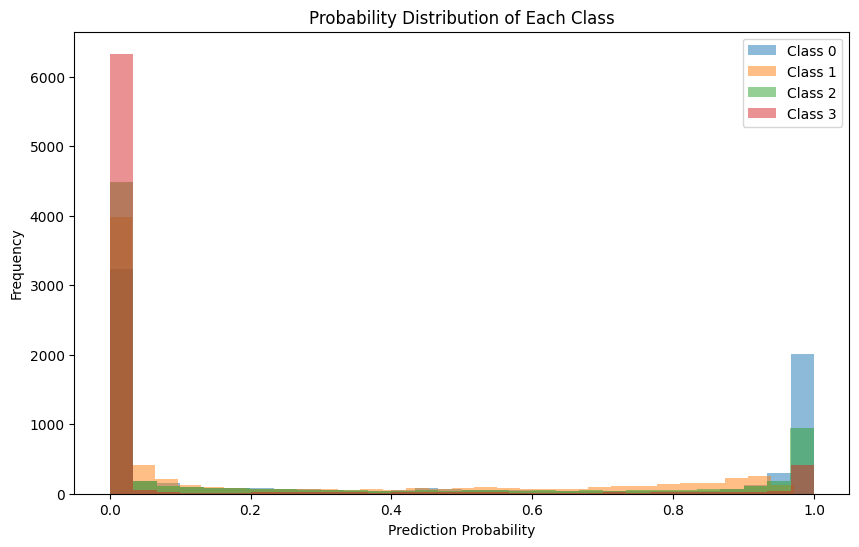


📌 Feature Statistics

[각 클래스별 평균값]
                  NTC       PM10      PM2.5     PM1.0        CT1        CT2  \
Pred_Label                                                                    
0           27.377306  20.011745  11.750671  7.993289   2.335574   1.098742   
1           28.961103  20.004965  11.992278  8.024820   2.861026   3.210838   
2           36.743519  19.992420  12.018408  7.987547   5.825403  24.698051   
3           47.555115  19.977207  11.995727  7.985755  12.865684  97.936195   

                  CT3        CT4  temp_max_value  ex_temperature  ex_humidity  \
Pred_Label                                                                      
0            0.510842   0.482896       46.893539       22.510067    35.495300   
1            1.312124   0.863403       58.835411       22.498070    35.493656   
2            9.918013   4.553265       74.602829       22.471575    35.492149   
3           36.780441  18.338161       88.665710       22.527065    35.501423   

  

In [3]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# ✅ 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ✅ 모델 로드
def load_trained_model(model_path):
    model = torch.load(model_path, map_location=device)  # 저장된 모델 전체 로드
    model.eval()  # 평가 모드
    print("✅ 모델 불러오기 완료")
    return model

# ✅ 데이터 로드
def load_test_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size):
    test_dataset = MultimodalDataset(csv_path, bin_root_folder, "test", img_dim_h, img_dim_w)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# ✅ 테스트 실행 함수
def evaluate_model(model, test_loader, features, num_classes):
    all_labels = []
    all_preds = []
    all_probs = []
    all_aux_data = []

    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)

            # ✅ Softmax 적용
            temperature = 2.0  # 온도 조정
            probs = torch.softmax(outputs / temperature, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_aux_data.extend(aux_data.cpu().numpy())

    # ✅ 결과 분석
    df_results = pd.DataFrame(all_aux_data, columns=features)
    df_results["True_Label"] = all_labels
    df_results["Pred_Label"] = all_preds
    df_results["Max_Prob"] = np.max(all_probs, axis=1)

    # ✅ 모델 성능 출력
    print("\n📊 Classification Report")
    print(classification_report(all_labels, all_preds, digits=4))

    # ✅ 예측 클래스 분포 확인
    unique, counts = np.unique(all_preds, return_counts=True)
    print("Predicted Class Distribution:", dict(zip(unique, counts)))

    # ✅ 확률 분포 시각화
    plt.figure(figsize=(10, 6))
    for class_idx in range(num_classes):
        class_probs = [prob[class_idx] for prob in all_probs]
        plt.hist(class_probs, bins=30, alpha=0.5, label=f"Class {class_idx}")

    plt.xlabel("Prediction Probability")
    plt.ylabel("Frequency")
    plt.title("Probability Distribution of Each Class")
    plt.legend()
    plt.show()

    # ✅ 변수별 평균값 출력
    print("\n📌 Feature Statistics")
    feature_means = df_results.groupby("Pred_Label")[features].mean()
    print("\n[각 클래스별 평균값]")
    print(feature_means)

    # ✅ Softmax가 특정 클래스에 몰리는지 확인
    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)
            print("Raw Logits:", outputs[:5])  # 처음 5개 샘플 출력
            print("Softmax Probabilities:", torch.softmax(outputs, dim=1)[:5])
            break  # 한 번만 확인

# ✅ 실행
if __name__ == "__main__":
    # 경로 설정
    csv_path = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/OHT/oht_merged_output.csv"
    bin_root_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/OHT"
    model_path = "OHT/oht12_best_model.pth"

    # 하이퍼파라미터 설정
    img_dim_h, img_dim_w = 120, 160
    batch_size = 16
    num_classes = 4
    features = [
        "NTC", "PM10", "PM2.5", "PM1.0",
        "CT1", "CT2", "CT3", "CT4",
        "temp_max_value", "ex_temperature",
        "ex_humidity", "ex_illuminance"
    ]

    # ✅ 모델 및 데이터 로드
    model = load_trained_model(model_path)
    test_loader = load_test_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size)

    # ✅ 테스트 평가
    evaluate_model(model, test_loader, features, num_classes)


In [9]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import time

# 1. 멀티모달 데이터셋 정의
class MultimodalDataset(Dataset):
    def __init__(self, csv_path, bin_root_folder, split_folder, img_dim_h, img_dim_w):
        self.data = []
        self.img_dim_h = img_dim_h
        self.img_dim_w = img_dim_w

        # 모든 BIN 파일의 경로 수집
        bin_files = {}
        split_path = os.path.join(bin_root_folder, split_folder)
        for root, _, files in os.walk(split_path):
            for file in files:
                if file.endswith(".bin"):
                    bin_files[file] = os.path.join(root, file)

        # CSV 파일 읽기
        df = pd.read_csv(csv_path)
        #features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value"]
        features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_temperature", "ex_humidity", "ex_illuminance"]

        for _, row in df.iterrows():
            bin_filename = row['bin_filename']
            if bin_filename in bin_files:
                bin_path = bin_files[bin_filename]
                try:
                    img_data = np.load(bin_path).reshape((img_dim_h, img_dim_w))
                except Exception as e:
                    print(f"[Error] BIN 파일 로드 실패: {bin_path}, {e}")
                    continue

                aux_data = row[features].values.astype(np.float32)
                label = int(row['state'])
                self.data.append((img_data, aux_data, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data, aux_data, label = self.data[idx]
        img_data = torch.tensor(img_data, dtype=torch.float32).unsqueeze(0)
        aux_data = torch.tensor(aux_data, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return img_data, aux_data, label


# 2. 데이터 로더 함수
def load_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size=32):
    train_dataset = MultimodalDataset(csv_path, bin_root_folder, 'train', img_dim_h, img_dim_w)
    val_dataset = MultimodalDataset(csv_path, bin_root_folder, 'val', img_dim_h, img_dim_w)
    test_dataset = MultimodalDataset(csv_path, bin_root_folder, 'test', img_dim_h, img_dim_w)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# 3. 모델 정의
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate=0.5):
        super().__init__()
        self.vit = nn.Transformer(
            d_model=embed_dim, nhead=num_heads, num_encoder_layers=depth,
            batch_first=True, dropout=dropout_rate
        )
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)
        x = patches + self.pos_embedding
        x = self.vit(x, x)
        x = self.dropout(x.mean(dim=1))
        return x


class SoftLabelEncoder(nn.Module):
    def __init__(self, aux_input_dim, embed_dim, dropout_rate=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(aux_input_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, aux_data):
        return self.fc(aux_data)


class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, query, key):
        attn_output, _ = self.attention(query, key, key)
        return attn_output


class ConditionClassifier(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes, dropout_rate=0.5):
        super().__init__()
        self.vit = ViTFeatureExtractor(img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate)
        self.soft_label_encoder = SoftLabelEncoder(aux_input_dim, embed_dim, dropout_rate)
        self.cross_attention = CrossAttention(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, images, aux_data):
        visual_features = self.vit(images)
        aux_features = self.soft_label_encoder(aux_data)
        visual_features = visual_features.unsqueeze(1)
        aux_features = aux_features.unsqueeze(1)
        integrated_features = self.cross_attention(visual_features, aux_features).squeeze(1)
        return self.classifier(integrated_features)


# 4. 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=30, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()

        # Training
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, aux_data, labels in train_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, aux_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, aux_data, labels in val_loader:
                images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
                outputs = model(images, aux_data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_accuracy = 100 * correct_val / total_val

        end_time = time.time()

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # ✅ 모델 전체 저장 방식으로 변경
            torch.save(model, "AGV/agv12_best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        # Scheduler step
        if scheduler:
            scheduler.step()

        # Print epoch results
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader):.4f}, "
              f"Train Accuracy = {train_accuracy:.2f}%, "
              f"Val Loss = {val_loss / len(val_loader):.4f}, "
              f"Val Accuracy = {val_accuracy:.2f}%, "
              f"Time = {end_time - start_time:.2f}s")

# 5. 실행
if __name__ == "__main__":
    csv_path = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV/agv_merged_output.csv"
    bin_root_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV"
    img_dim_h, img_dim_w = 120, 160
    aux_input_dim = 12
    num_classes = 4
    batch_size = 32

    # 데이터 로더 생성
    train_loader, val_loader, test_loader = load_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 모델 정의
    model = ConditionClassifier(
        img_dim_h, img_dim_w, patch_size=16, embed_dim=128, num_heads=4,
        depth=8, aux_input_dim=aux_input_dim, num_classes=num_classes, dropout_rate=0.2
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # 학습
    train_model(
        model, train_loader, val_loader, criterion, optimizer,
        scheduler, num_epochs=100, patience=8
    )

    # ✅ 모델 전체 로드 방식으로 변경
    model = torch.load("AGV/agv12_best_model.pth", map_location=device)
    model.eval()

    # 테스트
    correct = 0
    total = 0
    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


Using device: cuda
Epoch 1: Train Loss = 0.3144, Train Accuracy = 87.20%, Val Loss = 0.2305, Val Accuracy = 91.19%, Time = 74.38s
Epoch 2: Train Loss = 0.2168, Train Accuracy = 90.96%, Val Loss = 0.1705, Val Accuracy = 93.03%, Time = 74.61s
Epoch 3: Train Loss = 0.1996, Train Accuracy = 91.52%, Val Loss = 0.1528, Val Accuracy = 94.38%, Time = 76.20s
Epoch 4: Train Loss = 0.1937, Train Accuracy = 91.76%, Val Loss = 0.1784, Val Accuracy = 92.91%, Time = 85.01s
Epoch 5: Train Loss = 0.1920, Train Accuracy = 91.77%, Val Loss = 0.1936, Val Accuracy = 93.27%, Time = 85.58s
Epoch 6: Train Loss = 0.1711, Train Accuracy = 92.57%, Val Loss = 0.1442, Val Accuracy = 94.12%, Time = 78.23s
Epoch 7: Train Loss = 0.1728, Train Accuracy = 92.52%, Val Loss = 0.1619, Val Accuracy = 94.42%, Time = 77.89s
Epoch 8: Train Loss = 0.1722, Train Accuracy = 92.40%, Val Loss = 0.1967, Val Accuracy = 93.03%, Time = 73.74s
Epoch 9: Train Loss = 0.1682, Train Accuracy = 92.59%, Val Loss = 0.1849, Val Accuracy = 93.5

In [ ]:
#focal loss 적용

In [13]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import time
import torch.nn.functional as F

# 1. 멀티모달 데이터셋 정의
class MultimodalDataset(Dataset):
    def __init__(self, csv_path, bin_root_folder, split_folder, img_dim_h, img_dim_w):
        self.data = []
        self.img_dim_h = img_dim_h
        self.img_dim_w = img_dim_w

        # 모든 BIN 파일의 경로 수집
        bin_files = {}
        split_path = os.path.join(bin_root_folder, split_folder)
        for root, _, files in os.walk(split_path):
            for file in files:
                if file.endswith(".bin"):
                    bin_files[file] = os.path.join(root, file)

        # CSV 파일 읽기
        df = pd.read_csv(csv_path)
        #features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value"]
        features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", "temp_max_value", "ex_temperature", "ex_humidity", "ex_illuminance"]

        for _, row in df.iterrows():
            bin_filename = row['bin_filename']
            if bin_filename in bin_files:
                bin_path = bin_files[bin_filename]
                try:
                    img_data = np.load(bin_path).reshape((img_dim_h, img_dim_w))
                except Exception as e:
                    print(f"[Error] BIN 파일 로드 실패: {bin_path}, {e}")
                    continue

                aux_data = row[features].values.astype(np.float32)
                label = int(row['state'])
                self.data.append((img_data, aux_data, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data, aux_data, label = self.data[idx]
        img_data = torch.tensor(img_data, dtype=torch.float32).unsqueeze(0)
        aux_data = torch.tensor(aux_data, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return img_data, aux_data, label


# 2. 데이터 로더 함수
def load_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size=32):
    train_dataset = MultimodalDataset(csv_path, bin_root_folder, 'train', img_dim_h, img_dim_w)
    val_dataset = MultimodalDataset(csv_path, bin_root_folder, 'val', img_dim_h, img_dim_w)
    test_dataset = MultimodalDataset(csv_path, bin_root_folder, 'test', img_dim_h, img_dim_w)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# 3. 모델 정의
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate=0.5):
        super().__init__()
        self.vit = nn.Transformer(
            d_model=embed_dim, nhead=num_heads, num_encoder_layers=depth,
            batch_first=True, dropout=dropout_rate
        )
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)
        x = patches + self.pos_embedding
        x = self.vit(x, x)
        x = self.dropout(x.mean(dim=1))
        return x


class SoftLabelEncoder(nn.Module):
    def __init__(self, aux_input_dim, embed_dim, dropout_rate=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(aux_input_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, aux_data):
        return self.fc(aux_data)


class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, query, key):
        attn_output, _ = self.attention(query, key, key)
        return attn_output


class ConditionClassifier(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes, dropout_rate=0.5):
        super().__init__()
        self.vit = ViTFeatureExtractor(img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate)
        self.soft_label_encoder = SoftLabelEncoder(aux_input_dim, embed_dim, dropout_rate)
        self.cross_attention = CrossAttention(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, images, aux_data):
        visual_features = self.vit(images)
        aux_features = self.soft_label_encoder(aux_data)
        visual_features = visual_features.unsqueeze(1)
        aux_features = aux_features.unsqueeze(1)
        integrated_features = self.cross_attention(visual_features, aux_features).squeeze(1)
        return self.classifier(integrated_features)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        gamma: 어려운 샘플에 대한 가중치 조절 파라미터. (기본값: 2.0)
        alpha: 클래스별 가중치. 스칼라 또는 텐서로 지정할 수 있음.
        reduction: 'mean' 또는 'sum'으로 출력 손실을 집계하는 방식.
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: (batch_size, num_classes)
        # targets: (batch_size) - 각 원소는 0 ~ num_classes-1 사이의 정수
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # p_t = exp(-cross_entropy)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        # alpha가 지정된 경우, 각 샘플에 대한 가중치를 곱해줌
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_factor = self.alpha
            elif isinstance(self.alpha, torch.Tensor):
                alpha_factor = self.alpha[targets]
            else:
                raise TypeError("alpha must be float, int, or torch.Tensor")
            focal_loss = alpha_factor * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# 4. 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=30, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()

        # Training
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, aux_data, labels in train_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, aux_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, aux_data, labels in val_loader:
                images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
                outputs = model(images, aux_data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_accuracy = 100 * correct_val / total_val

        end_time = time.time()

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # ✅ 모델 전체 저장 방식으로 변경
            torch.save(model, "AGV/agv12_best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        # Scheduler step
        if scheduler:
            scheduler.step()

        # Print epoch results
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader):.4f}, "
              f"Train Accuracy = {train_accuracy:.2f}%, "
              f"Val Loss = {val_loss / len(val_loader):.4f}, "
              f"Val Accuracy = {val_accuracy:.2f}%, "
              f"Time = {end_time - start_time:.2f}s")

# 5. 실행
if __name__ == "__main__":
    csv_path = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV/agv_merged_output.csv"
    bin_root_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV"
    img_dim_h, img_dim_w = 120, 160
    aux_input_dim = 12
    num_classes = 4
    batch_size = 32

    # 데이터 로더 생성
    train_loader, val_loader, test_loader = load_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 모델 정의
    model = ConditionClassifier(
        img_dim_h, img_dim_w, patch_size=16, embed_dim=128, num_heads=4,
        depth=8, aux_input_dim=aux_input_dim, num_classes=num_classes, dropout_rate=0.5
    ).to(device)

    # 기존 CrossEntropyLoss 대신 Focal Loss 사용
    criterion = FocalLoss(gamma=2.0, alpha=0.25, reduction='mean')
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # 학습
    train_model(
        model, train_loader, val_loader, criterion, optimizer,
        scheduler, num_epochs=100, patience=8
    )

    # 최적 모델 로드 및 평가
    model = torch.load("AGV/agv12_best_model.pth", map_location=device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


Using device: cuda
Epoch 1: Train Loss = 0.0404, Train Accuracy = 82.52%, Val Loss = 0.0140, Val Accuracy = 91.81%, Time = 71.36s
Epoch 2: Train Loss = 0.0203, Train Accuracy = 88.76%, Val Loss = 0.0130, Val Accuracy = 92.00%, Time = 72.58s
Epoch 3: Train Loss = 0.0179, Train Accuracy = 89.60%, Val Loss = 0.0162, Val Accuracy = 90.60%, Time = 72.14s
Epoch 4: Train Loss = 0.0170, Train Accuracy = 90.11%, Val Loss = 0.0178, Val Accuracy = 90.12%, Time = 74.04s
Epoch 5: Train Loss = 0.0163, Train Accuracy = 90.27%, Val Loss = 0.0129, Val Accuracy = 93.19%, Time = 78.24s
Epoch 6: Train Loss = 0.0143, Train Accuracy = 91.17%, Val Loss = 0.0148, Val Accuracy = 93.19%, Time = 77.85s
Epoch 7: Train Loss = 0.0141, Train Accuracy = 91.28%, Val Loss = 0.0144, Val Accuracy = 92.76%, Time = 84.67s
Epoch 8: Train Loss = 0.0138, Train Accuracy = 91.64%, Val Loss = 0.0117, Val Accuracy = 93.88%, Time = 74.11s
Epoch 9: Train Loss = 0.0140, Train Accuracy = 91.31%, Val Loss = 0.0128, Val Accuracy = 93.0

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import time
import torch.nn.functional as F

# 1. 멀티모달 데이터셋 정의
class MultimodalDataset(Dataset):
    def __init__(self, csv_path, bin_root_folder, split_folder, img_dim_h, img_dim_w):
        self.data = []
        self.img_dim_h = img_dim_h
        self.img_dim_w = img_dim_w

        # 모든 BIN 파일의 경로 수집
        bin_files = {}
        split_path = os.path.join(bin_root_folder, split_folder)
        for root, _, files in os.walk(split_path):
            for file in files:
                if file.endswith(".bin"):
                    bin_files[file] = os.path.join(root, file)

        # CSV 파일 읽기
        df = pd.read_csv(csv_path)
        features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", 
                    "temp_max_value", "ex_temperature", "ex_humidity", "ex_illuminance"]

        for _, row in df.iterrows():
            bin_filename = row['bin_filename']
            if bin_filename in bin_files:
                bin_path = bin_files[bin_filename]
                try:
                    img_data = np.load(bin_path).reshape((img_dim_h, img_dim_w))
                except Exception as e:
                    print(f"[Error] BIN 파일 로드 실패: {bin_path}, {e}")
                    continue

                aux_data = row[features].values.astype(np.float32)
                label = int(row['state'])
                self.data.append((img_data, aux_data, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data, aux_data, label = self.data[idx]
        img_data = torch.tensor(img_data, dtype=torch.float32).unsqueeze(0)
        aux_data = torch.tensor(aux_data, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return img_data, aux_data, label


# 2. 데이터 로더 함수
def load_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size=32):
    train_dataset = MultimodalDataset(csv_path, bin_root_folder, 'train', img_dim_h, img_dim_w)
    val_dataset = MultimodalDataset(csv_path, bin_root_folder, 'val', img_dim_h, img_dim_w)
    test_dataset = MultimodalDataset(csv_path, bin_root_folder, 'test', img_dim_h, img_dim_w)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# 3. 모델 정의

class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate=0.5):
        super().__init__()
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        # LayerNorm 적용: 패치 임베딩 후
        self.norm1 = nn.LayerNorm(embed_dim)
        self.vit = nn.Transformer(
            d_model=embed_dim, nhead=num_heads, num_encoder_layers=depth,
            batch_first=True, dropout=dropout_rate
        )
        # LayerNorm 적용: Transformer 출력 후 (시퀀스 평균 전)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        patches = self.norm1(patches)
        x = patches + self.pos_embedding
        x = self.vit(x, x)  # Transformer 인코더
        # 시퀀스 차원에 대해 평균을 취한 후 정규화
        x = self.norm2(x.mean(dim=1))
        x = self.dropout(x)
        return x


class SoftLabelEncoder(nn.Module):
    def __init__(self, aux_input_dim, embed_dim, dropout_rate=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(aux_input_dim, embed_dim),
            nn.LayerNorm(embed_dim),  # 정규화 추가
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim)   # 정규화 추가
        )

    def forward(self, aux_data):
        return self.fc(aux_data)


class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)  # 어텐션 결과 후 정규화

    def forward(self, query, key):
        attn_output, _ = self.attention(query, key, key)
        # Residual 연결 후 정규화
        out = self.norm(query + attn_output)
        return out


class ConditionClassifier(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes, dropout_rate=0.5):
        super().__init__()
        self.vit = ViTFeatureExtractor(img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate)
        self.soft_label_encoder = SoftLabelEncoder(aux_input_dim, embed_dim, dropout_rate)
        self.cross_attention = CrossAttention(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, images, aux_data):
        visual_features = self.vit(images)              # (B, embed_dim)
        aux_features = self.soft_label_encoder(aux_data)   # (B, embed_dim)
        visual_features = visual_features.unsqueeze(1)     # (B, 1, embed_dim)
        aux_features = aux_features.unsqueeze(1)           # (B, 1, embed_dim)
        integrated_features = self.cross_attention(visual_features, aux_features).squeeze(1)
        return self.classifier(integrated_features)


class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        gamma: 어려운 샘플에 대한 가중치 조절 파라미터 (기본값: 2.0)
        alpha: 클래스별 가중치 (스칼라 또는 텐서)
        reduction: 'mean' 또는 'sum' 방식으로 집계
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_factor = self.alpha
            elif isinstance(self.alpha, torch.Tensor):
                alpha_factor = self.alpha[targets]
            else:
                raise TypeError("alpha must be float, int, or torch.Tensor")
            focal_loss = alpha_factor * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# 4. 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=30, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()

        # Training
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, aux_data, labels in train_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, aux_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, aux_data, labels in val_loader:
                images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
                outputs = model(images, aux_data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_accuracy = 100 * correct_val / total_val

        end_time = time.time()

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model, "AGV/agv12_best_model_0207.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        if scheduler:
            scheduler.step()

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader):.4f}, "
              f"Train Accuracy = {train_accuracy:.2f}%, "
              f"Val Loss = {val_loss / len(val_loader):.4f}, "
              f"Val Accuracy = {val_accuracy:.2f}%, "
              f"Time = {end_time - start_time:.2f}s")

# 5. 실행
if __name__ == "__main__":
    csv_path = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV/agv_merged_output.csv"
    bin_root_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV"
    img_dim_h, img_dim_w = 120, 160
    aux_input_dim = 12
    num_classes = 4
    batch_size = 32

    train_loader, val_loader, test_loader = load_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = ConditionClassifier(
        img_dim_h, img_dim_w, patch_size=16, embed_dim=128, num_heads=4,
        depth=8, aux_input_dim=aux_input_dim, num_classes=num_classes, dropout_rate=0.2
    ).to(device)

    # Focal Loss 사용
    criterion = FocalLoss(gamma=2.0, alpha=0.25, reduction='mean')
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_model(
        model, train_loader, val_loader, criterion, optimizer,
        scheduler, num_epochs=100, patience=8
    )

    model = torch.load("AGV/agv12_best_model_0207.pth", map_location=device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


Using device: cuda
Epoch 1: Train Loss = 0.0224, Train Accuracy = 88.36%, Val Loss = 0.0130, Val Accuracy = 92.22%, Time = 71.88s
Epoch 2: Train Loss = 0.0142, Train Accuracy = 91.14%, Val Loss = 0.0128, Val Accuracy = 92.10%, Time = 68.86s
Epoch 3: Train Loss = 0.0135, Train Accuracy = 91.32%, Val Loss = 0.0122, Val Accuracy = 92.76%, Time = 69.10s
Epoch 4: Train Loss = 0.0134, Train Accuracy = 91.34%, Val Loss = 0.0129, Val Accuracy = 92.60%, Time = 69.04s
Epoch 5: Train Loss = 0.0129, Train Accuracy = 91.53%, Val Loss = 0.0133, Val Accuracy = 93.43%, Time = 69.61s
Epoch 6: Train Loss = 0.0117, Train Accuracy = 92.35%, Val Loss = 0.0147, Val Accuracy = 94.18%, Time = 70.03s
Epoch 7: Train Loss = 0.0114, Train Accuracy = 92.41%, Val Loss = 0.0116, Val Accuracy = 93.98%, Time = 71.50s
Epoch 8: Train Loss = 0.0114, Train Accuracy = 92.55%, Val Loss = 0.0102, Val Accuracy = 94.93%, Time = 74.44s
Epoch 9: Train Loss = 0.0114, Train Accuracy = 92.41%, Val Loss = 0.0134, Val Accuracy = 93.1

FileNotFoundError: [Errno 2] No such file or directory: 'AGV/agv12_best_model_0207.pth'

In [ ]:
# cross attention 대신 gated fusion 추가

In [16]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import time
import torch.nn.functional as F

# 1. 멀티모달 데이터셋 정의
class MultimodalDataset(Dataset):
    def __init__(self, csv_path, bin_root_folder, split_folder, img_dim_h, img_dim_w):
        self.data = []
        self.img_dim_h = img_dim_h
        self.img_dim_w = img_dim_w

        # 모든 BIN 파일의 경로 수집
        bin_files = {}
        split_path = os.path.join(bin_root_folder, split_folder)
        for root, _, files in os.walk(split_path):
            for file in files:
                if file.endswith(".bin"):
                    bin_files[file] = os.path.join(root, file)

        # CSV 파일 읽기
        df = pd.read_csv(csv_path)
        features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", 
                    "temp_max_value", "ex_temperature", "ex_humidity", "ex_illuminance"]

        for _, row in df.iterrows():
            bin_filename = row['bin_filename']
            if bin_filename in bin_files:
                bin_path = bin_files[bin_filename]
                try:
                    img_data = np.load(bin_path).reshape((img_dim_h, img_dim_w))
                except Exception as e:
                    print(f"[Error] BIN 파일 로드 실패: {bin_path}, {e}")
                    continue

                aux_data = row[features].values.astype(np.float32)
                label = int(row['state'])
                self.data.append((img_data, aux_data, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data, aux_data, label = self.data[idx]
        img_data = torch.tensor(img_data, dtype=torch.float32).unsqueeze(0)
        aux_data = torch.tensor(aux_data, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return img_data, aux_data, label


# 2. 데이터 로더 함수
def load_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size=32):
    train_dataset = MultimodalDataset(csv_path, bin_root_folder, 'train', img_dim_h, img_dim_w)
    val_dataset = MultimodalDataset(csv_path, bin_root_folder, 'val', img_dim_h, img_dim_w)
    test_dataset = MultimodalDataset(csv_path, bin_root_folder, 'test', img_dim_h, img_dim_w)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# 3. 모델 정의

# (1) 이미지 특징 추출 및 정규화: ViTFeatureExtractor
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate=0.5):
        super().__init__()
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        self.norm1 = nn.LayerNorm(embed_dim)  # 패치 임베딩 후 정규화
        self.vit = nn.Transformer(
            d_model=embed_dim, nhead=num_heads, num_encoder_layers=depth,
            batch_first=True, dropout=dropout_rate
        )
        self.norm2 = nn.LayerNorm(embed_dim)  # Transformer 출력 후 정규화
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        patches = self.norm1(patches)
        x = patches + self.pos_embedding
        x = self.vit(x, x)
        x = self.norm2(x.mean(dim=1))
        x = self.dropout(x)
        return x


# (2) 보조 데이터 임베딩: SoftLabelEncoder
class SoftLabelEncoder(nn.Module):
    def __init__(self, aux_input_dim, embed_dim, dropout_rate=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(aux_input_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim)
        )

    def forward(self, aux_data):
        return self.fc(aux_data)


# (3) 멀티모달 피처 융합을 위한 Gated Fusion 모듈
class GatedFusion(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        # 두 모달리티의 임베딩을 연결하여 게이트 값을 산출 (값은 0~1 사이로 조정)
        self.fc_gate = nn.Linear(embed_dim * 2, embed_dim)
        
    def forward(self, visual, aux):
        # visual, aux: (B, embed_dim)
        combined = torch.cat([visual, aux], dim=1)  # (B, 2*embed_dim)
        gate = torch.sigmoid(self.fc_gate(combined)) # (B, embed_dim)
        # gate를 통해 visual과 aux의 기여도를 조절하여 융합
        fused = gate * visual + (1 - gate) * aux
        return fused


# (4) 최종 분류기: ConditionClassifier (Gated Fusion 적용)
class ConditionClassifier(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes, dropout_rate=0.5):
        super().__init__()
        self.vit = ViTFeatureExtractor(img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate)
        self.soft_label_encoder = SoftLabelEncoder(aux_input_dim, embed_dim, dropout_rate)
        # 기존 CrossAttention 대신 GatedFusion 모듈 사용
        self.gated_fusion = GatedFusion(embed_dim)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, images, aux_data):
        visual_features = self.vit(images)              # (B, embed_dim)
        aux_features = self.soft_label_encoder(aux_data)   # (B, embed_dim)
        fused_features = self.gated_fusion(visual_features, aux_features)  # (B, embed_dim)
        return self.classifier(fused_features)


# (5) Focal Loss (기존 코드와 동일)
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_factor = self.alpha
            elif isinstance(self.alpha, torch.Tensor):
                alpha_factor = self.alpha[targets]
            else:
                raise TypeError("alpha must be float, int, or torch.Tensor")
            focal_loss = alpha_factor * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# 4. 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=30, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()

        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, aux_data, labels in train_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, aux_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, aux_data, labels in val_loader:
                images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
                outputs = model(images, aux_data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_accuracy = 100 * correct_val / total_val

        end_time = time.time()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model, "AGV/agv12_best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        if scheduler:
            scheduler.step()

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader):.4f}, "
              f"Train Accuracy = {train_accuracy:.2f}%, "
              f"Val Loss = {val_loss / len(val_loader):.4f}, "
              f"Val Accuracy = {val_accuracy:.2f}%, "
              f"Time = {end_time - start_time:.2f}s")

# 5. 실행
if __name__ == "__main__":
    csv_path = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV/agv_merged_output.csv"
    bin_root_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV"
    img_dim_h, img_dim_w = 120, 160
    aux_input_dim = 12
    num_classes = 4
    batch_size = 32

    train_loader, val_loader, test_loader = load_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = ConditionClassifier(
        img_dim_h, img_dim_w, patch_size=16, embed_dim=128, num_heads=4,
        depth=8, aux_input_dim=aux_input_dim, num_classes=num_classes, dropout_rate=0.2
    ).to(device)

    criterion = FocalLoss(gamma=2.0, alpha=0.25, reduction='mean')
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_model(
        model, train_loader, val_loader, criterion, optimizer,
        scheduler, num_epochs=100, patience=8
    )

    model = torch.load("AGV/agv12_best_model.pth", map_location=device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


Using device: cuda
Epoch 1: Train Loss = 0.0224, Train Accuracy = 88.77%, Val Loss = 0.0136, Val Accuracy = 92.60%, Time = 75.64s
Epoch 2: Train Loss = 0.0134, Train Accuracy = 91.46%, Val Loss = 0.0134, Val Accuracy = 93.15%, Time = 75.49s
Epoch 3: Train Loss = 0.0128, Train Accuracy = 91.79%, Val Loss = 0.0101, Val Accuracy = 94.12%, Time = 75.63s
Epoch 4: Train Loss = 0.0124, Train Accuracy = 91.93%, Val Loss = 0.0121, Val Accuracy = 93.09%, Time = 76.21s
Epoch 5: Train Loss = 0.0122, Train Accuracy = 92.07%, Val Loss = 0.0112, Val Accuracy = 94.28%, Time = 75.97s
Epoch 6: Train Loss = 0.0112, Train Accuracy = 92.66%, Val Loss = 0.0119, Val Accuracy = 94.38%, Time = 76.11s
Epoch 7: Train Loss = 0.0110, Train Accuracy = 92.73%, Val Loss = 0.0118, Val Accuracy = 93.92%, Time = 75.86s
Epoch 8: Train Loss = 0.0110, Train Accuracy = 92.64%, Val Loss = 0.0117, Val Accuracy = 94.34%, Time = 76.24s
Epoch 9: Train Loss = 0.0107, Train Accuracy = 92.62%, Val Loss = 0.0130, Val Accuracy = 94.1

In [17]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import time
import torch.nn.functional as F

# 1. 멀티모달 데이터셋 정의
class MultimodalDataset(Dataset):
    def __init__(self, csv_path, bin_root_folder, split_folder, img_dim_h, img_dim_w):
        self.data = []
        self.img_dim_h = img_dim_h
        self.img_dim_w = img_dim_w

        # 모든 BIN 파일의 경로 수집
        bin_files = {}
        split_path = os.path.join(bin_root_folder, split_folder)
        for root, _, files in os.walk(split_path):
            for file in files:
                if file.endswith(".bin"):
                    bin_files[file] = os.path.join(root, file)

        # CSV 파일 읽기
        df = pd.read_csv(csv_path)
        features = ["NTC", "PM10", "PM2.5", "PM1.0", "CT1", "CT2", "CT3", "CT4", 
                    "temp_max_value", "ex_temperature", "ex_humidity", "ex_illuminance"]

        for _, row in df.iterrows():
            bin_filename = row['bin_filename']
            if bin_filename in bin_files:
                bin_path = bin_files[bin_filename]
                try:
                    img_data = np.load(bin_path).reshape((img_dim_h, img_dim_w))
                except Exception as e:
                    print(f"[Error] BIN 파일 로드 실패: {bin_path}, {e}")
                    continue

                aux_data = row[features].values.astype(np.float32)
                label = int(row['state'])
                self.data.append((img_data, aux_data, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data, aux_data, label = self.data[idx]
        img_data = torch.tensor(img_data, dtype=torch.float32).unsqueeze(0)
        aux_data = torch.tensor(aux_data, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return img_data, aux_data, label


# 2. 데이터 로더 함수
def load_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size=32):
    train_dataset = MultimodalDataset(csv_path, bin_root_folder, 'train', img_dim_h, img_dim_w)
    val_dataset = MultimodalDataset(csv_path, bin_root_folder, 'val', img_dim_h, img_dim_w)
    test_dataset = MultimodalDataset(csv_path, bin_root_folder, 'test', img_dim_h, img_dim_w)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# 3. 모델 정의

# (1) 이미지 특징 추출 및 정규화: ViTFeatureExtractor
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate=0.5):
        super().__init__()
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
        self.norm1 = nn.LayerNorm(embed_dim)  # 패치 임베딩 후 정규화
        self.vit = nn.Transformer(
            d_model=embed_dim, nhead=num_heads, num_encoder_layers=depth,
            batch_first=True, dropout=dropout_rate
        )
        self.norm2 = nn.LayerNorm(embed_dim)  # Transformer 출력 후 정규화
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        patches = self.norm1(patches)
        x = patches + self.pos_embedding
        x = self.vit(x, x)
        x = self.norm2(x.mean(dim=1))
        x = self.dropout(x)
        return x


# (2) 보조 데이터 임베딩: SoftLabelEncoder
class SoftLabelEncoder(nn.Module):
    def __init__(self, aux_input_dim, embed_dim, dropout_rate=0.5):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(aux_input_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim)
        )

    def forward(self, aux_data):
        return self.fc(aux_data)


# (3') 멀티모달 피처 융합을 위한 Bilinear Fusion 모듈
class BilinearFusion(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        # 곱셈한 결과를 재투영할 선형 계층
        self.fc = nn.Linear(embed_dim, embed_dim)
        self.relu = nn.ReLU()

    def forward(self, visual, aux):
        # visual, aux: (B, embed_dim)
        # Element-wise 곱셈을 통해 두 모달리티의 상호작용을 캡처
        fused = visual * aux  # (B, embed_dim)
        fused = self.relu(self.fc(fused))
        return fused


# (4') 최종 분류기: ConditionClassifier - Bilinear Fusion 적용
class ConditionClassifierBilinear(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes, dropout_rate=0.5):
        super().__init__()
        self.vit = ViTFeatureExtractor(img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth, dropout_rate)
        self.soft_label_encoder = SoftLabelEncoder(aux_input_dim, embed_dim, dropout_rate)
        # Gated Fusion 대신 Bilinear Fusion 사용
        self.bilinear_fusion = BilinearFusion(embed_dim)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, images, aux_data):
        visual_features = self.vit(images)              # (B, embed_dim)
        aux_features = self.soft_label_encoder(aux_data)   # (B, embed_dim)
        fused_features = self.bilinear_fusion(visual_features, aux_features)  # (B, embed_dim)
        return self.classifier(fused_features)



# (5) Focal Loss (기존 코드와 동일)
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_factor = self.alpha
            elif isinstance(self.alpha, torch.Tensor):
                alpha_factor = self.alpha[targets]
            else:
                raise TypeError("alpha must be float, int, or torch.Tensor")
            focal_loss = alpha_factor * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# 4. 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=30, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        start_time = time.time()

        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, aux_data, labels in train_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, aux_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, aux_data, labels in val_loader:
                images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
                outputs = model(images, aux_data)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_accuracy = 100 * correct_val / total_val

        end_time = time.time()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model, "AGV/agv12_best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        if scheduler:
            scheduler.step()

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(train_loader):.4f}, "
              f"Train Accuracy = {train_accuracy:.2f}%, "
              f"Val Loss = {val_loss / len(val_loader):.4f}, "
              f"Val Accuracy = {val_accuracy:.2f}%, "
              f"Time = {end_time - start_time:.2f}s")

# 5. 실행
if __name__ == "__main__":
    csv_path = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV/agv_merged_output.csv"
    bin_root_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV"
    img_dim_h, img_dim_w = 120, 160
    aux_input_dim = 12
    num_classes = 4
    batch_size = 32

    train_loader, val_loader, test_loader = load_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = ConditionClassifier(
        img_dim_h, img_dim_w, patch_size=16, embed_dim=128, num_heads=4,
        depth=8, aux_input_dim=aux_input_dim, num_classes=num_classes, dropout_rate=0.2
    ).to(device)

    criterion = FocalLoss(gamma=2.0, alpha=0.25, reduction='mean')
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_model(
        model, train_loader, val_loader, criterion, optimizer,
        scheduler, num_epochs=100, patience=8
    )

    model = torch.load("AGV/agv12_best_model.pth", map_location=device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")


Using device: cuda
Epoch 1: Train Loss = 0.0227, Train Accuracy = 88.49%, Val Loss = 0.0120, Val Accuracy = 93.73%, Time = 71.11s
Epoch 2: Train Loss = 0.0133, Train Accuracy = 91.43%, Val Loss = 0.0115, Val Accuracy = 93.23%, Time = 70.92s
Epoch 3: Train Loss = 0.0130, Train Accuracy = 91.78%, Val Loss = 0.0104, Val Accuracy = 94.20%, Time = 71.69s
Epoch 4: Train Loss = 0.0124, Train Accuracy = 91.99%, Val Loss = 0.0109, Val Accuracy = 93.53%, Time = 71.06s
Epoch 5: Train Loss = 0.0120, Train Accuracy = 92.15%, Val Loss = 0.0109, Val Accuracy = 93.25%, Time = 71.00s
Epoch 6: Train Loss = 0.0112, Train Accuracy = 92.56%, Val Loss = 0.0093, Val Accuracy = 94.24%, Time = 71.04s
Epoch 7: Train Loss = 0.0110, Train Accuracy = 92.69%, Val Loss = 0.0103, Val Accuracy = 94.40%, Time = 71.60s
Epoch 8: Train Loss = 0.0109, Train Accuracy = 92.74%, Val Loss = 0.0107, Val Accuracy = 94.44%, Time = 71.58s
Epoch 9: Train Loss = 0.0109, Train Accuracy = 92.73%, Val Loss = 0.0095, Val Accuracy = 94.2

Using device: cuda
모델 불러오기 완료

📊 Classification Report
              precision    recall  f1-score   support

           0     0.9328    0.9180    0.9253      2584
           1     0.8701    0.8006    0.8339      1088
           2     0.8658    0.8848    0.8752      1050
           3     0.7425    0.9788    0.8444       330

    accuracy                         0.8897      5052
   macro avg     0.8528    0.8955    0.8697      5052
weighted avg     0.8929    0.8897    0.8899      5052

Predicted Class Distribution: {0: 2543, 1: 1001, 2: 1073, 3: 435}


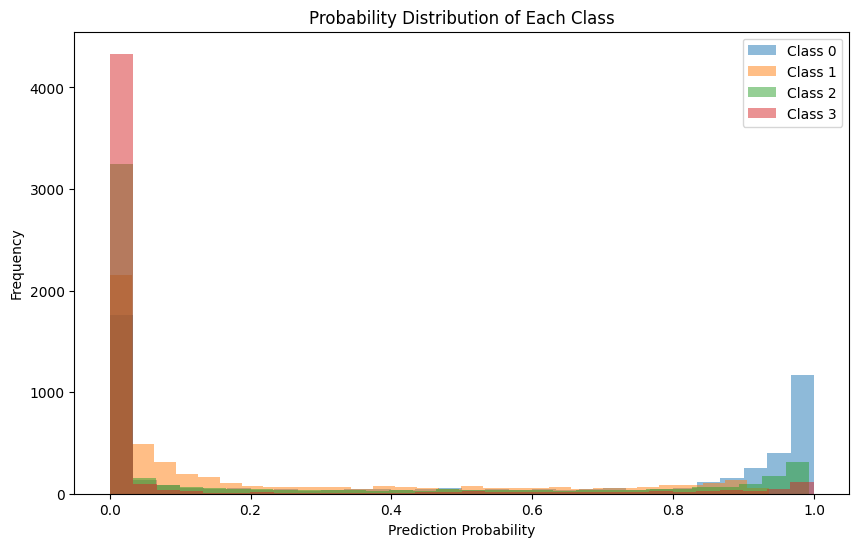


 Feature Statistics

[각 클래스별 평균값]
                  NTC       PM10      PM2.5      PM1.0        CT1         CT2  \
Pred_Label                                                                      
0           25.328815  45.924107  26.476603  20.867086   1.888156   74.907600   
1           33.848240  64.429573  35.728271  29.934067   2.229311   77.759644   
2           46.551517  79.486488  43.905872  36.574093   4.325107  103.002144   
3           55.996967  83.563217  46.101151  38.225288  11.998965  188.793961   

                  CT3        CT4  temp_max_value  ex_temperature  ex_humidity  \
Pred_Label                                                                      
0           49.736904  19.701286       48.639317       25.492725    30.465984   
1           50.959412  20.938372       68.617386       25.472527    30.538462   
2           60.373280  29.944008       88.822441       25.479963    30.447344   
3           90.458618  61.228874      107.409172       25.480459    30.45

In [7]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 로드
def load_trained_model(model_path):
    model = torch.load(model_path, map_location=device)  # 저장된 모델 전체 로드
    model.eval()  # 평가 모드
    print("모델 불러오기 완료")
    return model

# 데이터 로드
def load_test_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size):
    test_dataset = MultimodalDataset(csv_path, bin_root_folder, "test", img_dim_h, img_dim_w)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# 테스트 실행 함수
def evaluate_model(model, test_loader, features, num_classes):
    all_labels = []
    all_preds = []
    all_probs = []
    all_aux_data = []

    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)

            # Softmax 적용
            temperature = 2.0  # 온도 조정
            probs = torch.softmax(outputs / temperature, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_aux_data.extend(aux_data.cpu().numpy())

    # 결과 분석
    df_results = pd.DataFrame(all_aux_data, columns=features)
    df_results["True_Label"] = all_labels
    df_results["Pred_Label"] = all_preds
    df_results["Max_Prob"] = np.max(all_probs, axis=1)

    # 모델 성능 출력
    print("\n📊 Classification Report")
    print(classification_report(all_labels, all_preds, digits=4))

    # 예측 클래스 분포 확인
    unique, counts = np.unique(all_preds, return_counts=True)
    print("Predicted Class Distribution:", dict(zip(unique, counts)))

    # 확률 분포 시각화
    plt.figure(figsize=(10, 6))
    for class_idx in range(num_classes):
        class_probs = [prob[class_idx] for prob in all_probs]
        plt.hist(class_probs, bins=30, alpha=0.5, label=f"Class {class_idx}")

    plt.xlabel("Prediction Probability")
    plt.ylabel("Frequency")
    plt.title("Probability Distribution of Each Class")
    plt.legend()
    plt.show()

    # 변수별 평균값 출력
    print("\n Feature Statistics")
    feature_means = df_results.groupby("Pred_Label")[features].mean()
    print("\n[각 클래스별 평균값]")
    print(feature_means)

    # Softmax가 특정 클래스에 몰리는지 확인
    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)
            print("Raw Logits:", outputs[:5])  # 처음 5개 샘플 출력
            print("Softmax Probabilities:", torch.softmax(outputs, dim=1)[:5])
            break  # 한 번만 확인

# 실행
if __name__ == "__main__":
    # 경로 설정
    csv_path = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV/agv_merged_output.csv"
    bin_root_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV"
    model_path = "AGV/agv12_best_model.pth"

    # 하이퍼파라미터 설정
    img_dim_h, img_dim_w = 120, 160
    batch_size = 16
    num_classes = 4
    features = [
        "NTC", "PM10", "PM2.5", "PM1.0",
        "CT1", "CT2", "CT3", "CT4",
        "temp_max_value", "ex_temperature",
        "ex_humidity", "ex_illuminance"
    ]

    # 모델 및 데이터 로드
    model = load_trained_model(model_path)
    test_loader = load_test_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size)

    # 테스트 평가
    evaluate_model(model, test_loader, features, num_classes)


Using device: cuda
모델 불러오기 완료

📊 Classification Report
              precision    recall  f1-score   support

           0     0.9119    0.9288    0.9202      2584
           1     0.8811    0.7353    0.8016      1088
           2     0.8500    0.9124    0.8801      1050
           3     0.8104    0.9455    0.8727       330

    accuracy                         0.8848      5052
   macro avg     0.8633    0.8805    0.8687      5052
weighted avg     0.8857    0.8848    0.8832      5052

Predicted Class Distribution: {0: 2632, 1: 908, 2: 1127, 3: 385}


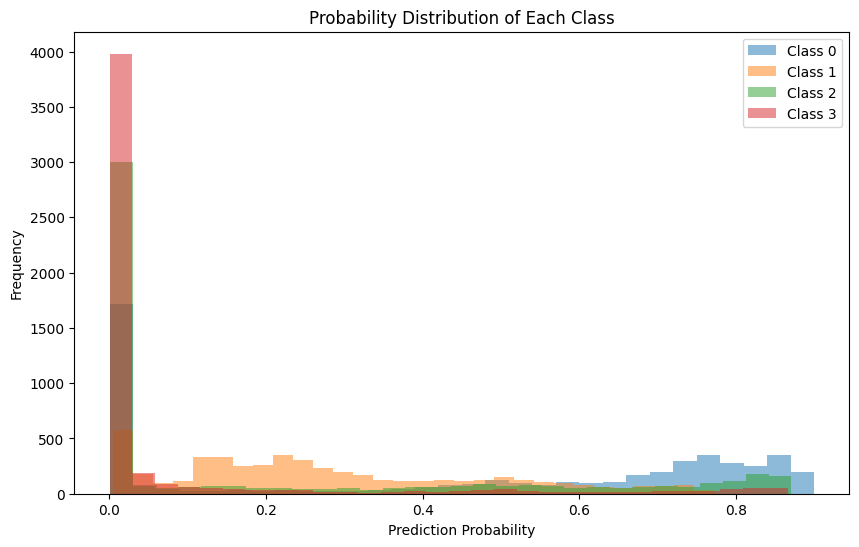


📊 각 클래스별 Feature Range

[각 클래스별 최소값]
                  NTC  PM10  PM2.5  PM1.0   CT1        CT2        CT3  \
Pred_Label                                                              
0           17.299999  38.0   20.0   16.0  1.50  74.400002  48.950001   
1           19.980000  52.0   26.0   23.0  1.68  74.820000  49.849998   
2           34.500000  67.0   38.0   31.0  1.60  74.779999  49.779999   
3           50.480000  78.0   42.0   34.0  1.40  74.839996  49.720001   

                  CT4  temp_max_value  ex_temperature  ex_humidity  \
Pred_Label                                                           
0           18.950001       35.910000            25.0         27.0   
1           19.900000       44.169998            25.0         27.0   
2           19.830000       59.950001            25.0         27.0   
3           19.670000       70.320000            25.0         27.0   

            ex_illuminance  
Pred_Label                  
0                    151.0  
1              

In [23]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# MultimodalDataset 클래스 (이전과 동일)
class MultimodalDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, bin_root_folder, split_folder, img_dim_h, img_dim_w):
        self.data = []
        self.img_dim_h = img_dim_h
        self.img_dim_w = img_dim_w

        # 모든 BIN 파일의 경로 수집
        bin_files = {}
        split_path = os.path.join(bin_root_folder, split_folder)
        for root, _, files in os.walk(split_path):
            for file in files:
                if file.endswith(".bin"):
                    bin_files[file] = os.path.join(root, file)

        # CSV 파일 읽기
        df = pd.read_csv(csv_path)
        features = ["NTC", "PM10", "PM2.5", "PM1.0",
                    "CT1", "CT2", "CT3", "CT4",
                    "temp_max_value", "ex_temperature", "ex_humidity", "ex_illuminance"]

        for _, row in df.iterrows():
            bin_filename = row['bin_filename']
            if bin_filename in bin_files:
                bin_path = bin_files[bin_filename]
                try:
                    img_data = np.load(bin_path).reshape((img_dim_h, img_dim_w))
                except Exception as e:
                    print(f"[Error] BIN 파일 로드 실패: {bin_path}, {e}")
                    continue

                aux_data = row[features].values.astype(np.float32)
                label = int(row['state'])
                self.data.append((img_data, aux_data, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data, aux_data, label = self.data[idx]
        img_data = torch.tensor(img_data, dtype=torch.float32).unsqueeze(0)
        aux_data = torch.tensor(aux_data, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return img_data, aux_data, label

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 로드
def load_trained_model(model_path):
    model = torch.load(model_path, map_location=device)  # 저장된 모델 전체 로드
    model.eval()  # 평가 모드
    print("모델 불러오기 완료")
    return model

# 데이터 로드
def load_test_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size):
    test_dataset = MultimodalDataset(csv_path, bin_root_folder, "test", img_dim_h, img_dim_w)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# 테스트 실행 함수
def evaluate_model(model, test_loader, features, num_classes):
    all_labels = []
    all_preds = []
    all_probs = []
    all_aux_data = []

    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)

            # Softmax 적용 (온도 조정)
            temperature = 2.0  
            probs = torch.softmax(outputs / temperature, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_aux_data.extend(aux_data.cpu().numpy())

    # 결과 분석 DataFrame 생성
    df_results = pd.DataFrame(all_aux_data, columns=features)
    df_results["True_Label"] = all_labels
    df_results["Pred_Label"] = all_preds
    df_results["Max_Prob"] = np.max(all_probs, axis=1)

    # 모델 성능 출력
    print("\n📊 Classification Report")
    print(classification_report(all_labels, all_preds, digits=4))

    # 예측 클래스 분포 확인
    unique, counts = np.unique(all_preds, return_counts=True)
    print("Predicted Class Distribution:", dict(zip(unique, counts)))

    # 확률 분포 시각화
    plt.figure(figsize=(10, 6))
    for class_idx in range(num_classes):
        class_probs = [prob[class_idx] for prob in all_probs]
        plt.hist(class_probs, bins=30, alpha=0.5, label=f"Class {class_idx}")
    plt.xlabel("Prediction Probability")
    plt.ylabel("Frequency")
    plt.title("Probability Distribution of Each Class")
    plt.legend()
    plt.show()

    # 각 클래스별 feature의 최소, 최대 및 범위(range) 계산
    print("\n📊 각 클래스별 Feature Range")
    groupby_state = df_results.groupby("Pred_Label")[features]
    feature_min = groupby_state.min()
    feature_max = groupby_state.max()
    feature_range = feature_max - feature_min
    print("\n[각 클래스별 최소값]")
    print(feature_min)
    print("\n[각 클래스별 최대값]")
    print(feature_max)
    print("\n[각 클래스별 범위 (Max - Min)]")
    print(feature_range)

    # 예시: 첫 5개 샘플의 Raw Logits와 Softmax 확률 확인
    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)
            print("Raw Logits:", outputs[:5])
            print("Softmax Probabilities:", torch.softmax(outputs, dim=1)[:5])
            break  # 한 번만 확인

# 실행
if __name__ == "__main__":
    # 경로 설정
    csv_path = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV/agv_merged_output.csv"
    bin_root_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV"
    model_path = "AGV/agv12_best_model.pth"

    # 하이퍼파라미터 설정
    img_dim_h, img_dim_w = 120, 160
    batch_size = 16
    num_classes = 4
    features = [
        "NTC", "PM10", "PM2.5", "PM1.0",
        "CT1", "CT2", "CT3", "CT4",
        "temp_max_value", "ex_temperature",
        "ex_humidity", "ex_illuminance"
    ]

    # 모델 및 데이터 로드
    model = load_trained_model(model_path)
    test_loader = load_test_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size)

    # 테스트 평가 및 각 state 별 feature 범위 확인
    evaluate_model(model, test_loader, features, num_classes)


Using device: cuda
모델 불러오기 완료

📊 Classification Report
              precision    recall  f1-score   support

           0     0.9119    0.9288    0.9202      2584
           1     0.8811    0.7353    0.8016      1088
           2     0.8500    0.9124    0.8801      1050
           3     0.8104    0.9455    0.8727       330

    accuracy                         0.8848      5052
   macro avg     0.8633    0.8805    0.8687      5052
weighted avg     0.8857    0.8848    0.8832      5052

Predicted Class Distribution: {0: 2632, 1: 908, 2: 1127, 3: 385}


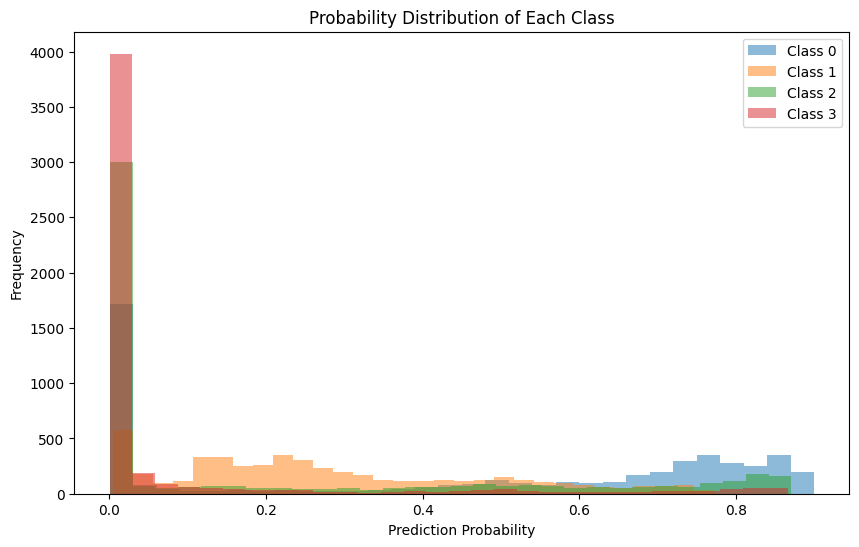


[각 클래스별 평균 Feature 값]
                  NTC       PM10      PM2.5      PM1.0        CT1         CT2  \
Pred_Label                                                                      
0           25.415476  46.191109  26.609423  20.998859   1.892173   74.927582   
1           34.446518  65.476875  36.223568  30.432819   2.270132   77.913864   
2           46.821117  79.573204  43.976044  36.614906   5.033443  104.485428   
3           56.268467  83.664932  46.158443  38.270130  10.855429  195.490448   

                  CT3        CT4  temp_max_value  ex_temperature  ex_humidity  \
Pred_Label                                                                      
0           49.747871  19.719061       49.217484       25.494680    30.464285   
1           51.029758  21.084173       68.762711       25.464758    30.569384   
2           61.031021  30.545572       89.550957       25.480036    30.417036   
3           92.384338  63.257923      107.803535       25.480520    30.498701   

   

In [24]:
import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# MultimodalDataset 클래스 (이전과 동일)
class MultimodalDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, bin_root_folder, split_folder, img_dim_h, img_dim_w):
        self.data = []
        self.img_dim_h = img_dim_h
        self.img_dim_w = img_dim_w

        # 모든 BIN 파일의 경로 수집
        bin_files = {}
        split_path = os.path.join(bin_root_folder, split_folder)
        for root, _, files in os.walk(split_path):
            for file in files:
                if file.endswith(".bin"):
                    bin_files[file] = os.path.join(root, file)

        # CSV 파일 읽기
        df = pd.read_csv(csv_path)
        features = ["NTC", "PM10", "PM2.5", "PM1.0",
                    "CT1", "CT2", "CT3", "CT4",
                    "temp_max_value", "ex_temperature", "ex_humidity", "ex_illuminance"]

        for _, row in df.iterrows():
            bin_filename = row['bin_filename']
            if bin_filename in bin_files:
                bin_path = bin_files[bin_filename]
                try:
                    img_data = np.load(bin_path).reshape((img_dim_h, img_dim_w))
                except Exception as e:
                    print(f"[Error] BIN 파일 로드 실패: {bin_path}, {e}")
                    continue

                aux_data = row[features].values.astype(np.float32)
                label = int(row['state'])
                self.data.append((img_data, aux_data, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_data, aux_data, label = self.data[idx]
        img_data = torch.tensor(img_data, dtype=torch.float32).unsqueeze(0)
        aux_data = torch.tensor(aux_data, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return img_data, aux_data, label

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 로드 함수
def load_trained_model(model_path):
    model = torch.load(model_path, map_location=device)  # 저장된 모델 전체 로드
    model.eval()  # 평가 모드
    print("모델 불러오기 완료")
    return model

# 데이터 로드 함수
def load_test_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size):
    test_dataset = MultimodalDataset(csv_path, bin_root_folder, "test", img_dim_h, img_dim_w)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# 평가 함수 (각 클래스별 feature 임계값 추가 계산)
def evaluate_model(model, test_loader, features, num_classes):
    all_labels = []
    all_preds = []
    all_probs = []
    all_aux_data = []

    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)

            # 온도 조정을 통한 softmax 적용
            temperature = 2.0  
            probs = torch.softmax(outputs / temperature, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_aux_data.extend(aux_data.cpu().numpy())

    # 결과 DataFrame 생성: 각 보조 feature와 실제/예측 레이블 저장
    df_results = pd.DataFrame(all_aux_data, columns=features)
    df_results["True_Label"] = all_labels
    df_results["Pred_Label"] = all_preds
    df_results["Max_Prob"] = np.max(all_probs, axis=1)

    # 모델 성능 출력
    print("\n📊 Classification Report")
    print(classification_report(all_labels, all_preds, digits=4))

    unique, counts = np.unique(all_preds, return_counts=True)
    print("Predicted Class Distribution:", dict(zip(unique, counts)))

    # 확률 분포 시각화
    plt.figure(figsize=(10, 6))
    for class_idx in range(num_classes):
        class_probs = [prob[class_idx] for prob in all_probs]
        plt.hist(class_probs, bins=30, alpha=0.5, label=f"Class {class_idx}")
    plt.xlabel("Prediction Probability")
    plt.ylabel("Frequency")
    plt.title("Probability Distribution of Each Class")
    plt.legend()
    plt.show()

    # 각 클래스별 feature 평균값 계산 (예측된 클래스 기준)
    print("\n[각 클래스별 평균 Feature 값]")
    groupby_state = df_results.groupby("Pred_Label")[features]
    feature_means = groupby_state.mean()
    print(feature_means)

    # 임계값 계산: 각 feature에 대해 인접 클래스의 평균값 중간값 산출
    print("\n[각 Feature별 임계값 (인접 클래스 평균 중간값)]")
    thresholds = {}  # {feature: {state_i vs state_j: threshold, ...}, ...}
    for feature in features:
        # 클래스별 평균을 클래스 레이블 순으로 정렬 (0, 1, 2, 3 등)
        means = feature_means[feature].sort_index()
        feature_thresholds = {}
        for i in range(len(means) - 1):
            # 인접한 두 클래스의 평균값 중간값을 임계값으로 산출
            thresh = (means.iloc[i] + means.iloc[i + 1]) / 2.0
            feature_thresholds[f"State {means.index[i]} vs State {means.index[i+1]}"] = thresh
        thresholds[feature] = feature_thresholds
        print(f"{feature}: {feature_thresholds}")

    # 예시로 첫 5개 샘플의 Raw Logits와 Softmax 확률 확인
    with torch.no_grad():
        for images, aux_data, labels in test_loader:
            images, aux_data, labels = images.to(device), aux_data.to(device), labels.to(device)
            outputs = model(images, aux_data)
            print("Raw Logits (first 5 samples):", outputs[:5])
            print("Softmax Probabilities (first 5 samples):", torch.softmax(outputs, dim=1)[:5])
            break

# 실행
if __name__ == "__main__":
    csv_path = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV/agv_merged_output.csv"
    bin_root_folder = "C:/Users/82103/Desktop/multimodal/train(01~14)val(15~16)test(17~18)/AGV"
    model_path = "AGV/agv12_best_model.pth"

    # 하이퍼파라미터 설정
    img_dim_h, img_dim_w = 120, 160
    batch_size = 16
    num_classes = 4
    features = [
        "NTC", "PM10", "PM2.5", "PM1.0",
        "CT1", "CT2", "CT3", "CT4",
        "temp_max_value", "ex_temperature",
        "ex_humidity", "ex_illuminance"
    ]

    model = load_trained_model(model_path)
    test_loader = load_test_data(csv_path, bin_root_folder, img_dim_h, img_dim_w, batch_size)

    evaluate_model(model, test_loader, features, num_classes)


In [2]:
import torch
print(torch.__version__)

1.9.0+cu111
